<a href="https://colab.research.google.com/github/adrianmarino/wide-and-deep-example/blob/master/Wide_%26_Deep_Features_Columns%2BAuto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://chromium.googlesource.com/external/github.com/tensorflow/tensorflow/+/r0.10/tensorflow/g3doc/tutorials/wide/index.md
* https://colab.research.google.com/drive/1sr35BcvzYfZB3s-H_NRoaDx4N3wtI0II

 Probability that the individual has an annual income of over 50,000 dollars.
 

In [ ]:
!pip install urllib3
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import feature_column

import pandas as pd
import tempfile
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import DenseFeatures, Dense, concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

import collections

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
fc = feature_column
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.3.0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

Tesla T4, 15079 MiB


In [ ]:
def show_column(name, values):
    print(f'{name.capitalize()}({len(values)}): {values}')

def column_values(df, name):
    values = df[name].unique()
    show_column(name, values)
    return values

def duplicate_columns(df, columns, postfix='2'):
    for column in columns:
        df[f'{column}_{postfix}'] = df[column]

class DataSource:
    # Define the column names for the data sets.
    LABEL_COLUMN = 'label'

    COLUMNS = [
        "age", "workclass", "fnlwgt", "education", "education_num",
        "marital_status", "occupation", "relationship", "race", "gender",
        "capital_gain", "capital_loss", "hours_per_week", "native_country", 
        "income_bracket"
    ]
    CATEGORICAL_COLUMNS = [
        "workclass", "education", "marital_status", "occupation",
        "relationship", "race", "gender", "native_country"
    ]
    CONTINUOUS_COLUMNS = [
        "age", "education_num", "capital_gain", "capital_loss", "hours_per_week"
    ]

    DUPLICATED_COLUMNS = [
        'workclass', 
        'education',
        'marital_status',
        'gender',
        'relationship',
        'race',
        'native_country',
        'occupation'
    ]

    def __init__(self):
        self.train_file = tempfile.NamedTemporaryFile()
        self.test_file = tempfile.NamedTemporaryFile()
        urllib.request.urlretrieve(
            "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
            self.train_file.name
        )
        urllib.request.urlretrieve(
            "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", 
            self.test_file.name
        )

    def __prepare_data(
        self,
        file,  
        target_column="income_bracket", 
        skiprows=None
    ):
        df = pd.read_csv(
            file, 
            names=DataSource.COLUMNS, 
            skipinitialspace=True, 
            skiprows=skiprows
        )
        df[DataSource.LABEL_COLUMN] = (df[target_column].apply(lambda x: ">50K" in x)).astype(int)
        df.pop(target_column)
        return df


    
    def load_data(self):
        df_train = self.__prepare_data(self.train_file)
        df_test = self.__prepare_data(self.test_file, skiprows=1)
        
        duplicate_columns(df_train, columns=DataSource.DUPLICATED_COLUMNS)
        duplicate_columns(df_test, columns=DataSource.DUPLICATED_COLUMNS)

        return df_train, df_test

datasource = DataSource()
df_train, df_test = datasource.load_data()
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,label,workclass_2,education_2,marital_status_2,gender_2,relationship_2,race_2,native_country_2,occupation_2
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,State-gov,Bachelors,Never-married,Male,Not-in-family,White,United-States,Adm-clerical
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Male,Husband,White,United-States,Exec-managerial
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,Private,HS-grad,Divorced,Male,Not-in-family,White,United-States,Handlers-cleaners
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,Private,11th,Married-civ-spouse,Male,Husband,Black,United-States,Handlers-cleaners
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Private,Bachelors,Married-civ-spouse,Female,Wife,Black,Cuba,Prof-specialty


In [ ]:

df_train, df_test = train_test_split(df_train, test_size=0.2)
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(len(df_train), 'train examples')
print(len(df_val), 'validation examples')
print(len(df_test), 'test examples')

20838 train examples
5210 validation examples
6513 test examples


In [ ]:
class FeatureColumn:
    @staticmethod
    def num(name): return fc.numeric_column(name)

    @staticmethod
    def num_bucketized(name, boundaries):
        return fc.bucketized_column(FeatureColumn.num(name), boundaries=boundaries)

    @staticmethod
    def cat(name, values): 
        return fc.categorical_column_with_vocabulary_list(name, values)

    @staticmethod
    def cat_one_hot(name, values): 
        return fc.indicator_column(FeatureColumn.cat(name, values))
     
    @staticmethod
    def cat_one_hot_crossed(columns, hash_bucket_size=1000): 
        return fc.indicator_column(fc.crossed_column(columns, hash_bucket_size=hash_bucket_size))

    @staticmethod
    def cat_embedding(name, values, dimension=8):
        return fc.embedding_column(FeatureColumn.cat(name, values), dimension=dimension)

class ModelInputBuilder:
    def __init__(self): 
        self.__inputs = {}
        self.__feature_columns = []

    def num(self, name):
        column = FeatureColumn.num(name)
        self.__feature_columns.append(column)
        self.input(name, tf.int64)
        return column

    def num_bucketized(self, name, boundaries):        
        column = FeatureColumn.num_bucketized(name, boundaries)
        self.__feature_columns.append(column)
        self.input(name, tf.string)
        return column

    def cat_one_hot(self, name, values):
        cat_col = fc.categorical_column_with_vocabulary_list(name, values)
        self.__feature_columns.append(fc.indicator_column(cat_col))
        self.input(name, tf.string)
        return cat_col

    def cat_one_hot_crossed(self, columns, hash_bucket_size=1000):
        column = FeatureColumn.cat_one_hot_crossed(columns, hash_bucket_size)
        self.__feature_columns.append(column)
        return column

    def cat_embedding(self, name, values, dimension=8):
        column = FeatureColumn.cat_embedding(name, values, dimension)
        self.__feature_columns.append(column)
        self.input(name, tf.string)
        return column

    def input(self, name, type):
        if name not in self.__inputs:
            self.__inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=type)

    def inputs_dic(self): return self.__inputs
    
    def inputs(self): return self.__inputs.values()

    def feature_columns(self): return self.__feature_columns

In [ ]:
genders = column_values(df_train, 'gender')
races = column_values(df_train, 'race')
educations = column_values(df_train, 'education')
relationships = column_values(df_train, 'relationship')
workclasses = column_values(df_train, 'workclass')
occupations = column_values(df_train, 'occupation')
native_countries = column_values(df_train, 'native_country')
marital_statuses = column_values(df_train, 'marital_status')

Gender(2): ['Male' 'Female']
Race(5): ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
Education(16): ['Bachelors' 'Some-college' 'HS-grad' '10th' 'Assoc-voc' '12th' '11th'
 '9th' 'Prof-school' 'Doctorate' 'Masters' '5th-6th' 'Assoc-acdm'
 '7th-8th' '1st-4th' 'Preschool']
Relationship(6): ['Husband' 'Unmarried' 'Own-child' 'Not-in-family' 'Other-relative' 'Wife']
Workclass(9): ['Self-emp-inc' 'Private' 'Local-gov' 'Self-emp-not-inc' '?' 'State-gov'
 'Federal-gov' 'Never-worked' 'Without-pay']
Occupation(15): ['Machine-op-inspct' 'Sales' 'Adm-clerical' 'Transport-moving'
 'Craft-repair' 'Prof-specialty' 'Tech-support' 'Handlers-cleaners'
 'Other-service' 'Farming-fishing' '?' 'Exec-managerial' 'Protective-serv'
 'Priv-house-serv' 'Armed-Forces']
Native_country(42): ['United-States' 'Peru' 'Mexico' 'Ireland' 'France' 'Germany' 'Hungary'
 'South' 'Canada' '?' 'Puerto-Rico' 'China' 'Portugal' 'Honduras' 'Japan'
 'Taiwan' 'Jamaica' 'Vietnam' 'Cuba' 'Italy' 'Dominican-Repu

In [ ]:
wide_inputs = ModelInputBuilder()

wide_inputs.num("education_num")
wide_inputs.num("age")
age_buckets = wide_inputs.num_bucketized(
    "age", 
    [18, 25, 30, 35, 40, 45, 50, 55, 60, 65]
)
wide_inputs.cat_one_hot("race", races)
wide_inputs.cat_one_hot("gender", genders)
wide_inputs.cat_one_hot("workclass", workclasses)
wide_inputs.cat_one_hot("marital_status", marital_statuses)
wide_inputs.cat_one_hot("relationship", relationships)

native_country_cat  = wide_inputs.cat_one_hot("native_country", native_countries)
education_cat       = wide_inputs.cat_one_hot("education", educations)
occupation_cat      = wide_inputs.cat_one_hot("occupation", occupations)

wide_inputs.cat_one_hot_crossed(columns=[education_cat,  occupation_cat], hash_bucket_size=int(100))
wide_inputs.cat_one_hot_crossed(columns=[native_country_cat, occupation_cat], hash_bucket_size=1000)
wide_inputs.cat_one_hot_crossed(columns=[age_buckets, education_cat, occupation_cat], hash_bucket_size=1000)

IndicatorColumn(categorical_column=CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65)), VocabularyListCategoricalColumn(key='education', vocabulary_list=('Bachelors', 'Some-college', 'HS-grad', '10th', 'Assoc-voc', '12th', '11th', '9th', 'Prof-school', 'Doctorate', 'Masters', '5th-6th', 'Assoc-acdm', '7th-8th', '1st-4th', 'Preschool'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='occupation', vocabulary_list=('Machine-op-inspct', 'Sales', 'Adm-clerical', 'Transport-moving', 'Craft-repair', 'Prof-specialty', 'Tech-support', 'Handlers-cleaners', 'Other-service', 'Farming-fishing', '?', 'Exec-managerial', 'Protective-serv', 'Priv-house-serv', 'Armed-Forces'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), hash_bucket_size=1000, hash_key=None))

In [ ]:
deep_inputs = ModelInputBuilder()

deep_inputs.num("capital_gain")
deep_inputs.num("capital_loss")
deep_inputs.num("hours_per_week")

deep_inputs.cat_embedding("workclass_2", workclasses, dimension=8)
deep_inputs.cat_embedding("education_2", educations, dimension=8)
deep_inputs.cat_embedding("marital_status_2", marital_statuses, dimension=8)
deep_inputs.cat_embedding("gender_2", marital_statuses, dimension=8)
deep_inputs.cat_embedding("relationship_2", relationships, dimension=8)
deep_inputs.cat_embedding("race_2", races, dimension=8)
deep_inputs.cat_embedding("native_country_2", native_countries, dimension=8)
deep_inputs.cat_embedding("occupation_2", occupations, dimension=8)

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='occupation_2', vocabulary_list=('Machine-op-inspct', 'Sales', 'Adm-clerical', 'Transport-moving', 'Craft-repair', 'Prof-specialty', 'Tech-support', 'Handlers-cleaners', 'Other-service', 'Farming-fishing', '?', 'Exec-managerial', 'Protective-serv', 'Priv-house-serv', 'Armed-Forces'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=8, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f03e597cba8>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)

In [ ]:
Act = collections.namedtuple('Act', 'values default')
Unit = collections.namedtuple('Unit', 'min_value max_value step default')
Layer = collections.namedtuple('Layer', 'unit act')

class WideAndDeepHyperModel(HyperModel):
    def __init__(
        self,
        wide_input_setttings, 
        deep_input_setttings,
        deep_hidden_layers,
        lr,
        loss='binary_crossentropy',
        metrics=['accuracy']
    ):
        self.__wide_input_setttings = wide_input_setttings 
        self.__deep_input_setttings = deep_input_setttings
        self.__deep_hidden_layers = deep_hidden_layers
        self.__lr = lr
        self.__loss = loss,
        self.__metrics = metrics

    def build(self, hp):
        wide = DenseFeatures(
            self.__wide_input_setttings.feature_columns(), 
            name='Wide_Features'
        )(self.__wide_input_setttings.inputs_dic())

        deep = DenseFeatures(
            self.__deep_input_setttings.feature_columns(), 
            name='Deep_Features'
        )(self.__deep_input_setttings.inputs_dic())

        for idx, layer in enumerate(self.__deep_hidden_layers):
            layer_name = f'Deep_Hidden_{idx+1}'
            deep = Dense(
                name=layer_name,
                units=hp.Int(
                    f'{layer_name}.units',
                    min_value=layer.unit.min_value,
                    max_value=layer.unit.max_value,
                    step=layer.unit.step,
                    default=layer.unit.default
                ),
                activation=hp.Choice(
                    f'{layer_name}.activation',
                    values=layer.act.values,
                    default=layer.act.default
                )
            )(deep)
            
        both = concatenate([deep, wide], name='Deep_Wide')

        output = Dense(1, activation='sigmoid', name='Output')(both)

        inputs = list(self.__wide_input_setttings.inputs()) + \
                    list(self.__deep_input_setttings.inputs())

        model = Model(inputs, output)

        model.compile(
            optimizer=Adam(lr=hp.Choice('learning_rate', values=self.__lr)),
            loss=self.__loss,
            metrics=self.__metrics
        )

        return model

In [ ]:
deep_hidden_layers=[
    Layer(
        unit=Unit(min_value=100, max_value=200, step=25, default=100),
        act=Act(values=['relu'], default='relu')
    ),
    Layer(
        unit=Unit(min_value=25, max_value=100, step=25, default=50),
        act=Act(values=['relu'], default='relu')
    )
]
lr=[1e-2, 1e-3, 1e-4]

hyper_model = WideAndDeepHyperModel(wide_inputs, deep_inputs, deep_hidden_layers, lr)

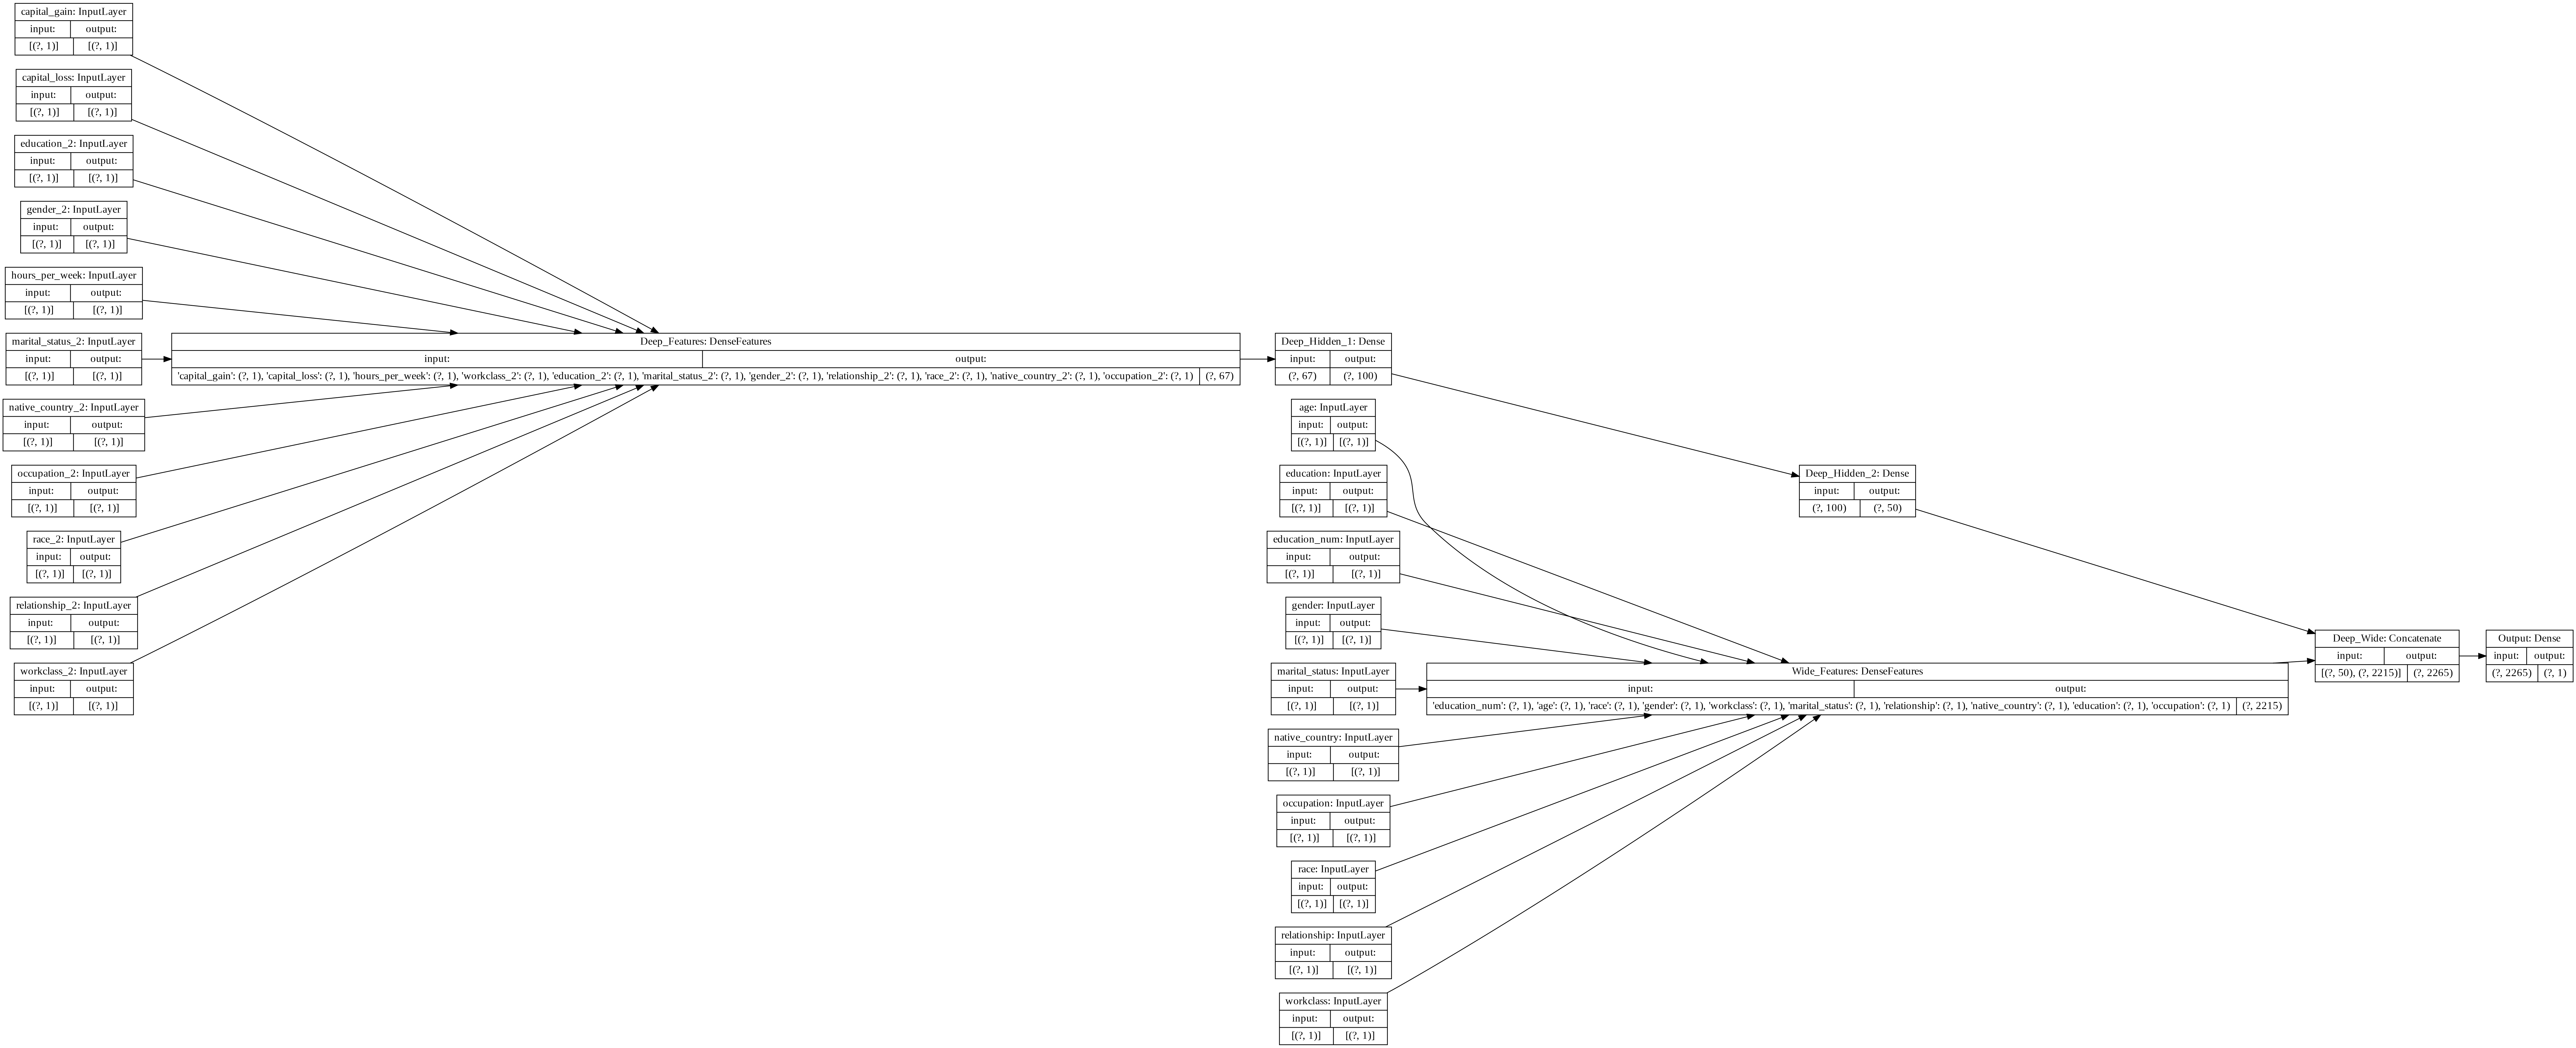

In [ ]:
from tensorflow.keras.utils import plot_model

def plot_default_hyper_model(hyper_model, show_shapes=True, show_layer_names=True, dpi="200", rankdir="LR"):
    model = hyper_model.build(HyperParameters())
    return plot_model(
        model, 
        show_shapes=show_shapes, 
        show_layer_names=show_layer_names, 
        dpi=dpi, 
        rankdir=rankdir
    )

plot_default_hyper_model(hyper_model)

In [ ]:
tuner = Hyperband(
    hyper_model,
    objective='val_accuracy',
    max_epochs=200,
    project_name='50_000_>=_income_prod'
)

'''
tuner = RandomSearch(
    hyper_model,
    max_trials=60,
    objective='val_accuracy',
    directory='hyperband',
    project_name='50_000_>=_income_prod'
)
'''

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./50_000_>=_income_prod/oracle.json
INFO:tensorflow:Reloading Tuner from ./50_000_>=_income_prod/tuner0.json


In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_column_name, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(target_column_name)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
batch_size = 4096

train_ds = df_to_dataset(
    df_train, 
    DataSource.LABEL_COLUMN, 
    batch_size=batch_size
)
val_ds = df_to_dataset(
    df_val, 
    DataSource.LABEL_COLUMN, 
    shuffle=False, 
    batch_size=batch_size
)
test_ds = df_to_dataset(
    df_test, 
    DataSource.LABEL_COLUMN, 
    shuffle=False, 
    batch_size=batch_size
)

train_ds.cache()
val_ds.cache()
test_ds.cache()

<CacheDataset shapes: ({age: (None,), workclass: (None,), fnlwgt: (None,), education: (None,), education_num: (None,), marital_status: (None,), occupation: (None,), relationship: (None,), race: (None,), gender: (None,), capital_gain: (None,), capital_loss: (None,), hours_per_week: (None,), native_country: (None,), workclass_2: (None,), education_2: (None,), marital_status_2: (None,), gender_2: (None,), relationship_2: (None,), race_2: (None,), native_country_2: (None,), occupation_2: (None,)}, (None,)), types: ({age: tf.int64, workclass: tf.string, fnlwgt: tf.int64, education: tf.string, education_num: tf.int64, marital_status: tf.string, occupation: tf.string, relationship: tf.string, race: tf.string, gender: tf.string, capital_gain: tf.int64, capital_loss: tf.int64, hours_per_week: tf.int64, native_country: tf.string, workclass_2: tf.string, education_2: tf.string, marital_status_2: tf.string, gender_2: tf.string, relationship_2: tf.string, race_2: tf.string, native_country_2: tf.str

In [ ]:
tuner.search(train_ds, validation_data=val_ds, batch_size=batch_size)

In [ ]:
# Show a summary of the search
tuner.results_summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Retrieve the best model.
best_hp = tuner.get_best_hyperparameters(num_trials=10)[3]
model = tuner.hypermodel.build(best_hp)

N_EPOCH_SEARCH = 200
callbacks      = [EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.0001,
    patience=20,
    verbose=1
)]

model.fit(
    train_ds, 
    validation_data=val_ds, 
    batch_size=batch_size, 
    epochs=N_EPOCH_SEARCH, 
    callbacks=callbacks
)

Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['fnlwgt'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


6/6 [==============================] - 1s 198ms/step - loss: 4.2416 - accuracy: 0.7746 - val_loss: 0.8009 - val_accuracy: 0.7818
Epoch 2/200
6/6 [==============================] - 0s 77ms/step - loss: 1.1084 - accuracy: 0.7811 - val_loss: 0.8639 - val_accuracy: 0.7831
Epoch 3/200
6/6 [==============================] - 0s 75ms/step - loss: 0.6901 - accuracy: 0.7840 - val_loss: 0.5131 - val_accuracy: 0.7814
Epoch 4/200
6/6 [==============================] - 0s 78ms/step - loss: 0.4305 - accuracy: 0.8136 - val_loss: 0.4024 - val_accuracy: 0.8278
Epoch 5/200
6/6 [==============================] - 0s 75ms/step - loss: 0.3747 - accuracy: 0.8277 - val_loss: 0.3527 - val_accuracy: 0.8380
Epoch 6/200
6/6 [==============================] - 0s 78ms/step - loss: 0.3540 - accuracy: 0.8329 - val_loss: 0.3451 - val_accuracy: 0.8388
Epoch 7/200
6/6 [==============================] - 0s 77ms/step - loss: 0.4222 - accuracy: 0.8364 - val_loss: 0.3470 - val_accuracy: 0.8455
Epoch 8/200
6/6 [==============

In [ ]:
results = model.evaluate(test_ds, batch_size=batch_size)
print('Loss:', results[0], '- Accuracy:', results[1])

2/2 [==============================] - 0s 24ms/step - loss: 0.3112 - accuracy: 0.8571
Loss: 0.31119465827941895 - Accuracy: 0.857055127620697
